In [1]:
import random
import numpy as np

random.seed(5)  # Set the seed for Python's random module
np.random.seed(10)  # Set the seed for numpy's random module

In [2]:
from cabm import cabm_agent

In [3]:
model = cabm_agent.ConsumerModel(1000, "config.toml", enable_ads=False)

/Users/MikeFitzgerald/Documents/GitHub/consumer-abm/cabm/cabm_helpers/agent_and_model_functions.py:26: UserWarning: Beta Sampler Override is in effect.
  warnings.warn("Beta Sampler Override is in effect.")
/Users/MikeFitzgerald/Documents/GitHub/consumer-abm/cabm/cabm_helpers/agent_and_model_functions.py:13: UserWarning: Normal Sampler Override is in effect.
  warnings.warn("Normal Sampler Override is in effect.")


In [4]:
for i in range(110):
    model.step()

In [5]:
model_df = model.datacollector.get_model_vars_dataframe()

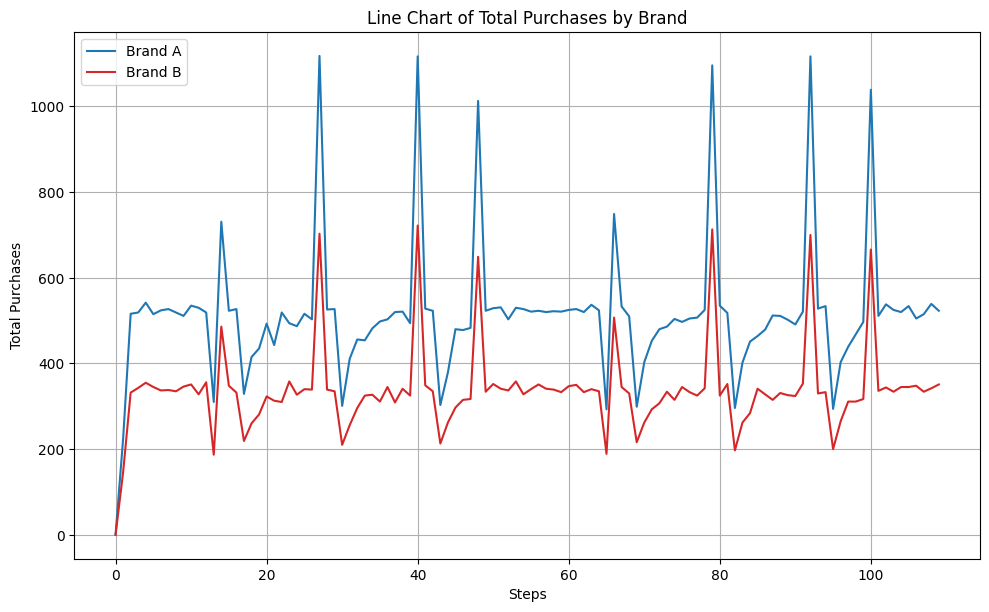

In [6]:
import matplotlib.pyplot as plt

# Extract purchases by brand
model_df['Total_Purchases_A'] = model_df['Total_Purchases'].apply(lambda x: x['A'])
model_df['Total_Purchases_B'] = model_df['Total_Purchases'].apply(lambda x: x['B'])

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.set_ylabel('Total Purchases')
ax1.set_xlabel('Steps')

# Plot total purchases for brand A
color = 'tab:blue'
ax1.plot(model_df['Total_Purchases_A'], color=color, label='Brand A')

# Plot total purchases for brand B
color = 'tab:red'
ax1.plot(model_df['Total_Purchases_B'], color=color, label='Brand B')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Line Chart of Total Purchases by Brand')
plt.grid(True)
plt.legend(loc='upper left')  # Add legend to the plot
plt.show()

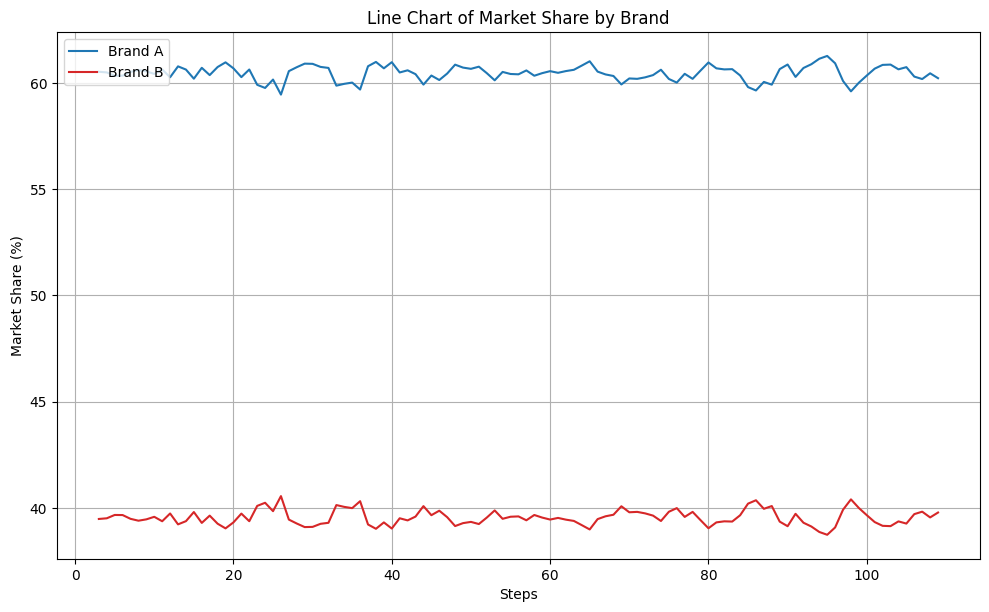

In [7]:

# Compute the monthly average for each brand
model_df['Monthly_Average_A'] = model_df['Total_Purchases_A'].rolling(window=4).mean()
model_df['Monthly_Average_B'] = model_df['Total_Purchases_B'].rolling(window=4).mean()

# Compute the total monthly average
model_df['Total_Monthly_Average'] = model_df['Monthly_Average_A'] + model_df['Monthly_Average_B']

# Compute the market share percentage for each brand
model_df['Market_Share_A'] = (model_df['Monthly_Average_A'] / model_df['Total_Monthly_Average']) * 100
model_df['Market_Share_B'] = (model_df['Monthly_Average_B'] / model_df['Total_Monthly_Average']) * 100

fig, ax2 = plt.subplots(figsize=(10,6))
ax2.set_ylabel('Market Share (%)')
ax2.set_xlabel('Steps')

# Plot market share for brand A
color = 'tab:blue'
ax2.plot(model_df['Market_Share_A'], color=color, label='Brand A')

# Plot market share for brand B
color = 'tab:red'
ax2.plot(model_df['Market_Share_B'], color=color, label='Brand B')

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title('Line Chart of Market Share by Brand')
plt.grid(True)
plt.legend(loc='upper left')  # Add legend to the plot
plt.show()



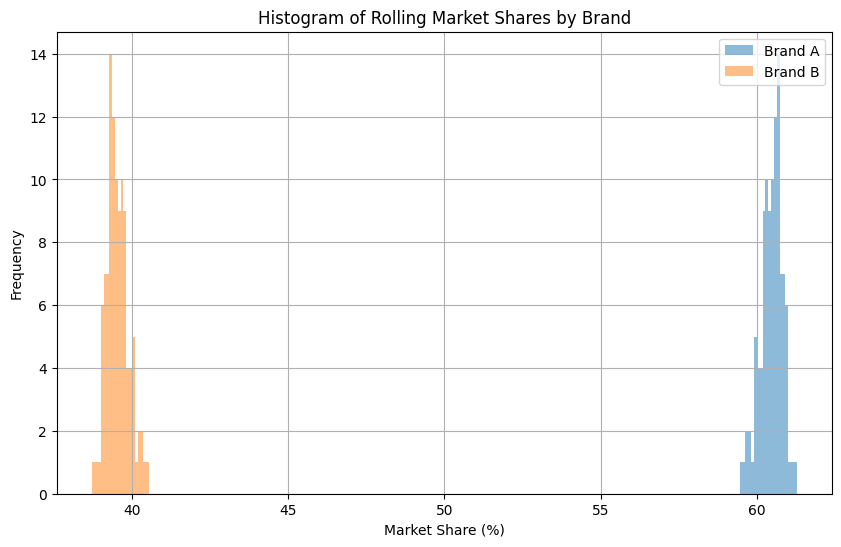

In [8]:
# Plot histogram of rolling market shares for brand A
plt.figure(figsize=(10,6))
plt.hist(model_df['Market_Share_A'], bins=20, alpha=0.5, label='Brand A')

# Plot histogram of rolling market shares for brand B
plt.hist(model_df['Market_Share_B'], bins=20, alpha=0.5, label='Brand B')

plt.title('Histogram of Rolling Market Shares by Brand')
plt.xlabel('Market Share (%)')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()


In [9]:
agent_summary_df = model.datacollector.get_agent_vars_dataframe()

In [10]:
def check_multiple_purchases(df):
    # Define a function to check if more than one value in the dictionary is greater than 0
    def more_than_one_purchase(purchases):
        return sum(value > 0 for value in purchases.values()) > 1

    # Apply the function to the 'Purchased_This_Step' column
    multiple_purchases = df['Purchased_This_Step'].apply(more_than_one_purchase)

    # Return True if there are any cases of multiple purchases, False otherwise
    return any(multiple_purchases)

# Usage:
print(check_multiple_purchases(agent_summary_df))

False


In [11]:
def count_letter_changes(series):
    # Compute the difference between consecutive letters
    letter_changes = series != series.shift()

    # Ignore the first value
    letter_changes = letter_changes.iloc[1:]

    # Sum the letter_changes series to get the number of letter changes
    change_count = letter_changes.sum()

    return change_count

In [13]:
letter_change_counts = [count_letter_changes(agent_summary_df.xs(agent_id, level='AgentID')['Brand_Preference']) for agent_id in agent_summary_df.index.get_level_values('AgentID').unique()]


In [15]:
sum(letter_change_counts)

0